In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import torch.nn.functional as F

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


In [3]:
# Hyperparmeters
batch_size = 64
vocab_size = 65
block_size = 256
max_iters = 3000
eval_intervals = 300
learning_rate = 3e-4
n_embd = 384
n_head = 4
n_layer = 6
dropout = 0.2
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
def load_dataset(path='input.txt'):
    with open(path, 'r',encoding='utf-8') as f:
        text = f.read()

    chars = sorted(list(set(text)))
    vocab_size = len(chars)

    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[n] for n in l])

    data = torch.tensor(encode(text), dtype=torch.long)

    # Split once and return both splits
    split_idx = int(0.9 * len(data))
    train_data = data[:split_idx]
    val_data = data[split_idx:]

    return {
        'train_data': train_data,
        'val_data': val_data,
        'vocab_size': vocab_size,
        'stoi': stoi,
        'itos': itos,
        'encode': encode,
        'decode': decode
    }

In [5]:
load_dataset()

{'train_data': tensor([18, 47, 56,  ..., 43, 56, 43]),
 'val_data': tensor([12,  0,  0,  ..., 45,  8,  0]),
 'vocab_size': 65,
 'stoi': {'\n': 0,
  ' ': 1,
  '!': 2,
  '$': 3,
  '&': 4,
  "'": 5,
  ',': 6,
  '-': 7,
  '.': 8,
  '3': 9,
  ':': 10,
  ';': 11,
  '?': 12,
  'A': 13,
  'B': 14,
  'C': 15,
  'D': 16,
  'E': 17,
  'F': 18,
  'G': 19,
  'H': 20,
  'I': 21,
  'J': 22,
  'K': 23,
  'L': 24,
  'M': 25,
  'N': 26,
  'O': 27,
  'P': 28,
  'Q': 29,
  'R': 30,
  'S': 31,
  'T': 32,
  'U': 33,
  'V': 34,
  'W': 35,
  'X': 36,
  'Y': 37,
  'Z': 38,
  'a': 39,
  'b': 40,
  'c': 41,
  'd': 42,
  'e': 43,
  'f': 44,
  'g': 45,
  'h': 46,
  'i': 47,
  'j': 48,
  'k': 49,
  'l': 50,
  'm': 51,
  'n': 52,
  'o': 53,
  'p': 54,
  'q': 55,
  'r': 56,
  's': 57,
  't': 58,
  'u': 59,
  'v': 60,
  'w': 61,
  'x': 62,
  'y': 63,
  'z': 64},
 'itos': {0: '\n',
  1: ' ',
  2: '!',
  3: '$',
  4: '&',
  5: "'",
  6: ',',
  7: '-',
  8: '.',
  9: '3',
  10: ':',
  11: ';',
  12: '?',
  13: 'A',
  14:

In [6]:
from bigram import BigramLanguageModel,load_dataset
dataset = load_dataset('input.txt')
decode = dataset['decode']
encode = dataset['encode']

In [7]:
model = BigramLanguageModel(vocab_size,n_embd,n_head,block_size,dropout)

In [8]:
state = torch.load("bigram_model_weights.pth", map_location="cpu") 
model.load_state_dict(state)
model.to(device)

BigramLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=384, out_features=96, bias=False)
            (query): Linear(in_features=384, out_features=96, bias=False)
            (value): Linear(in_features=384, out_features=96, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_aff

In [9]:
model.to(device).eval()
idx = torch.zeros((1, 1), dtype=torch.long, device=device)

In [10]:
def generate(self, idx, max_tokens):
    # Get device from model parameters
    device = next(self.parameters()).device
    
    # Ensure input tensor is on the correct device
    idx = idx.to(device)
    
    for _ in range(max_tokens):
        # Clip context window
        idx_cond = idx[:, -block_size:]
        
        # Forward pass
        logits, loss = self(idx_cond)
        
        # Get last logits and compute probabilities
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        
        # Sample next token (will inherit device from probs)
        idnext = torch.multinomial(probs, num_samples=1)
        
        # Concatenate with running sequence
        idx = torch.cat((idx, idnext), dim=1)
    
    return idx

In [11]:
# Generate text
with torch.no_grad():
    out = model.generate(idx, max_tokens=1000)

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
print(f"Model device: {next(model.parameters()).device}")
print(f"Input device: {idx.device}")
print(f"Output device: {out.device}")

Model device: mps:0
Input device: mps:0


NameError: name 'out' is not defined

In [ ]:
print(''.join(decode(out[0].tolist())))


Leave me insible Tyrrel, if you persuade me certain a
promise-keys! I dreamter, not but 't.

PERDITA:
Prepare you, sir, an you say?

POLIXENES:
Even in your honour impose:
This Hery brother's name, banishment's gladly,
Silence we are but by your judgment-seath!
Fearest with the foe, Northphy, nor me.
I cannot petence nor ago: there thoughts now,
Some shall gentle to those by-walls.
Away with his tale stone nobing wife;
A pright tenous vantage brawled floads with miss,
So doubtle prince and him, and married himself
The judge, to a fooler, nay on the tractor,
In that he doth vengeance of the closet,
Were equest, where were best our to kitle way,
Shook upon the hazards: we that thither came
To conquire the than you sought with cholers,
Lead, the heart of my baggage, consider
Even to make him at a figure.

JOHN OF GAUNT:
What stir the worlds are is here small an approbation.

KING RICHARD II:
How have't! lay the hours me a sworn hour names!
How canst he love to help.

JOHN OF GAUNT:
Whate

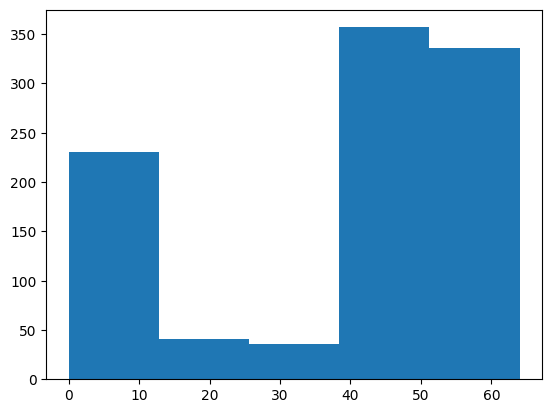

In [ ]:
plt.hist(out[0],bins=5)
plt.show()

In [ ]:
print(torch.__version__, "mps available:", torch.backends.mps.is_available())

2.7.1 mps available: True


In [ ]:
for name, p in model.named_parameters():
    print(name, p.device)
print("input device:", idx.device)

token_embedding_table.weight mps:0
position_embedding_table.weight mps:0
blocks.0.sa.heads.0.key.weight mps:0
blocks.0.sa.heads.0.query.weight mps:0
blocks.0.sa.heads.0.value.weight mps:0
blocks.0.sa.heads.1.key.weight mps:0
blocks.0.sa.heads.1.query.weight mps:0
blocks.0.sa.heads.1.value.weight mps:0
blocks.0.sa.heads.2.key.weight mps:0
blocks.0.sa.heads.2.query.weight mps:0
blocks.0.sa.heads.2.value.weight mps:0
blocks.0.sa.heads.3.key.weight mps:0
blocks.0.sa.heads.3.query.weight mps:0
blocks.0.sa.heads.3.value.weight mps:0
blocks.0.sa.proj.weight mps:0
blocks.0.sa.proj.bias mps:0
blocks.0.ffwd.net.0.weight mps:0
blocks.0.ffwd.net.0.bias mps:0
blocks.0.ffwd.net.2.weight mps:0
blocks.0.ffwd.net.2.bias mps:0
blocks.0.ln1.weight mps:0
blocks.0.ln1.bias mps:0
blocks.0.ln2.weight mps:0
blocks.0.ln2.bias mps:0
blocks.1.sa.heads.0.key.weight mps:0
blocks.1.sa.heads.0.query.weight mps:0
blocks.1.sa.heads.0.value.weight mps:0
blocks.1.sa.heads.1.key.weight mps:0
blocks.1.sa.heads.1.query.wei